# **piView**
## Pixxel Viewer Hyperspectral Tutorial Notebook

**Summary**  

In this notebook we will open a Level 2A (L2A) Reflectance product file (ENVI file format) from Pixxel's Tech Demonstrator 1 (TD1) satellite imager, as well as an associated uncertainty product. We will inspect the data and plot interactive data viewers using various python modules as well as get an introduction to some basic hyperspectral analysis techniques. We will then run an unsupervised clustering approach on the hyperspectral data which will  group similar spectral features together in the image. This can be very useful for identifying different levels of vegetation stress. We will finish with an example of how to utilize spectral similarity to identify target spectra. Our TD1 images are at 30m GSD and range between 60-70 bands between 470 nm - 900 nm.      

The L2A Reflectance Product contains estimated surface reflectance. Surface reflectance is the fraction of incoming solar radiation reflected Earth's surface. Materials reflect proportions of radiation differently based upon their chemical composition.  This means that reflectance information can be used to determine the composition of a target. In this guide you will learn how to plot a band from the L2A reflectance spatially and look at the spectral curve associated with individual pixels. Note that these images are from pototype satellites, Pixxel's operational hyperspectral FireFly constellation will be launching in January 2025. 

**Requirements** 
 - Conda environment https://www.anaconda.com/download
 - See **setup_instructions.md** in the /setup/ folder

**Learning Objectives**  
- How to open an Pixxel TD1 file as an xarray.Dataset
- How to plot specific bands as images
- How to make an interactive plot to visualize spectra
- How to apply PCA and understand information content
- How to apply vegetation indices
- How to cluster the image and create a classification map
- How to run a spectral angle mapper to identify pixels of interest

**Tutorial Outline**  

1. Load modules  
2. Filepaths and band centers  
3. Load data cube 
4. Visualization  
5. Introduction to hyperspectral analysis  
6. Case study: Assessing vegetation health using hyperspectral imagery 
7. Case study: Spectral similarity to identify certain mineral type

## 1. Load Modules

In [2]:
from lib2 import *

gv.extension('bokeh',) 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

/Users/jeremy/miniforge3/envs/pixxel_viewer/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 2. Filepaths and Band Centers

Input filepaths to the ENVI formated image cube and associated uncertainty files and to the metadata header file (hdr). The image products need to be aquired from Pixxel separately.

 **BE SURE TO CHANGE PATHS TO WHERE YOU STORE THE FILES LOCALLY.**

In [4]:
# path to image and uncertianty cubes
fpath = '/Users/jeremy/images/TD1_8660_L0_V1/isofit/output/8660_rfl_rfl'
fpath_unc = '/Users/jeremy/images/TD1_8660_L0_V1/isofit/output/8660_uncert_uncert'

# path to metadata file
hdrpath = '/Users/jeremy/images/TD1_8660_L0_V1/isofit/output/8660_rfl_rfl.hdr'

# parse center wavelengths and FWHM from header file
wavelengths, fwhms = parse_hdr_file(hdrpath)

# Display the results
print("Wavelengths:", wavelengths)
print("FWHM:", fwhms)

Wavelengths: [490.0, 493.0, 497.0, 500.5, 501.5, 505.0, 508.5, 512.0, 516.0, 519.0, 522.5, 525.5, 531.0, 534.5, 537.5, 540.5, 544.5, 547.5, 551.0, 554.0, 555.0, 558.0, 561.0, 564.0, 568.5, 571.0, 573.5, 577.0, 582.0, 594.0, 597.0, 603.0, 604.0, 606.5, 609.0, 688.0, 690.5, 694.0, 744.0, 747.5, 750.0, 753.5, 756.0, 759.0, 761.5, 766.0, 768.5, 772.0, 774.0, 778.0, 781.0, 784.0, 786.0, 794.5, 797.5, 799.5, 803.0, 821.0, 823.5, 827.0, 829.0, 866.5, 868.5, 871.5, 874.5, 877.0]
FWHM: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]


## 3. Load Data Cubes

We will use the module xarray for loading the image cube. Xarray is a powerful Python library for working with labeled multi-dimensional arrays, making it ideal for hyperspectral image (HSI) analysis. It simplifies handling HSI data cubes by associating meaningful labels (e.g., wavelengths and spatial coordinates) with each axis, enabling intuitive exploration and manipulation. Xarray supports efficient slicing, indexing, and scalable computation through integration with Dask, allowing users to process large datasets seamlessly. It also facilitates I/O for common HSI formats and integrates well with tools like NumPy and Matplotlib, making tasks such as spectral filtering, band reduction, and visualization more efficient.

We will need to replace the band numbers in the xarray dataset with center wavelengths. This will be beneficial for spectral plotting.

In [20]:
# open dataset as xarray dataset
data = rioxarray.open_rasterio(fpath, driver='ENVI')
unc = rioxarray.open_rasterio(fpath_unc, driver='ENVI')

# replace band numbers with wavelengths
# Check if the number of wavelengths matches the number of bands
if len(wavelengths) == data.band.size:
    # Replace the band numbers with wavelength values
    data = data.swap_dims({'band':'wavelength'})
    # data = xr.open_dataarray(path)
    data.name = 'reflectance'
else:
    print("The number of wavelengths does not match the number of bands in the image dataset.")

if len(wavelengths) == unc.band.size:
    # Replace the band numbers with wavelength values
    unc = unc.swap_dims({'band':'wavelength'})
    # data = xr.open_dataarray(path)
    unc.name = 'uncertainty'
else:
    print("The number of wavelengths does not match the number of bands in the uncertainty dataset.")


print (data)
print (unc)

<xarray.DataArray 'reflectance' (wavelength: 66, y: 3089, x: 1596)>
[325382904 values with dtype=float32]
Coordinates:
    fwhm         (wavelength) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
  * wavelength   (wavelength) float64 490.0 493.0 497.0 ... 871.5 874.5 877.0
    band         (wavelength) int64 1 2 3 4 5 6 7 8 ... 59 60 61 62 63 64 65 66
  * x            (x) float64 7.568e+05 7.569e+05 ... 8.047e+05 8.047e+05
  * y            (y) float64 2.408e+06 2.408e+06 ... 2.315e+06 2.315e+06
    spatial_ref  int64 0
Attributes: (12/86)
    Band_1:                    490.0 nanometers
    Band_10:                   519.0 nanometers
    Band_11:                   522.5 nanometers
    Band_12:                   525.5 nanometers
    Band_13:                   531.0 nanometers
    Band_14:                   534.5 nanometers
    ...                        ...
    header_offset:             0
    interleave:                bil
    lines:                     3089
    samples:               

## 4. Visualization

### 4.1 Band data

Creates a discrete slider for band selection based on wavelengths. The toolbar to the right of the plot provides functionality to move around the image using your mouse, zoom by defining an AOI, or zoom using the mouse scroller. Click the refresh button to refresh the image to default view. The save button allows you to save a quick PNG of the current band selection. 

**If slider is not working, rerun the code cell**

In [ ]:
# replace -9999 fill values with nan
data = data.where(data != -9999, np.nan)

# interactive band visualizer
# Create a discrete slider for band selection based on wavelengths
# Assuming data is loaded and properly formatted
plot = data.hvplot(x='x', y='y', 
                       groupby='wavelength',  # Group by band
                    #    geo=True, 
                       cmap='gray',
                       # cnorm='log', 
                       aspect='equal', 
                       rasterize=True, 
                    #    clim=(0,.3),
                    #    crs=ccrs.PlateCarree(),
                    #    tiles='EsriImagery',
                       width=800,
                       height=800,
                       widget_location='top')

pn.serve(plot) 
# plot

Launching server at http://localhost:51689


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### 4.2 Uncertainty data

The uncertainty product derived from the ISOFIT atmospheric correction quantifies the confidence in the retrieval of surface reflectance values. It provides pixel-wise estimates of uncertainty, accounting for factors such as atmospheric variability, sensor noise, and model assumptions. This product is crucial for hyperspectral analysis, enabling users to assess the reliability of derived reflectance data, guide decision-making in downstream applications, and enhance the interpretation of results by incorporating error margins directly into analyses.

We can visualize the uncertainty products as individual bands similar to how we viewed the band data.

In [21]:
# replace -9999 fill values with nan
unc = unc.where(unc != -9999, np.nan)

# interactive band visualizer
# Create a discrete slider for band selection based on wavelengths
# Assuming data is loaded and properly formatted
plot = unc.hvplot(x='x', y='y', 
                       groupby='wavelength',  # Group by band
                    #    geo=True, 
                       cmap='viridis', # cnorm='log', 
                       clim=(0,.08),
                       aspect='equal', 
                       rasterize=True, 
                    #    crs=ccrs.PlateCarree(),
                    #    tiles='EsriImagery',
                       width=800,
                       height=800,
                       widget_location='top')

pn.serve(plot)
# plot 



Launching server at http://localhost:51747


### 4.3 Spectral-Spatial Mapping

Visualizing spatial and spectral data together provides a dynamic way to explore imaging spectroscopy datasets. Using the streams module from Holoviews, we can link a spatial map with spectral plots for interactive analysis. Instead of displaying a single-band image, constructing an RGB composite by combining three bands offers a clearer view of the scene and helps identify key features.

To create an RGB image, select bands corresponding to red (650 nm), green (560 nm), and blue (470 nm) by matching them to the nearest available wavelengths. With tools like pointerXY and Tap from the holoviews.streams module, we can build an interactive setup: one tool tracks the cursor's position over the spatial map, while the other captures clicked locations. A custom function then uses these coordinates to extract and compare spectra from the image. This allows real-time comparison of spectral data from where the cursor hovers and specific points of interest, offering a deeper understanding of pixel-level reflectance patterns. 

In [8]:
# Assuming 'data' and 'unc' are your xarray DataArrays
# transform linear_stretch or brighten
rgb_norm = spec_viz(data, unc, transform='brighten')


Launching server at http://localhost:51709


## 5. Introduction to Hyperspectral Analysis

We can now reshape the dataset into a big contiguous list of spectra, i.e. a 2-D matrix of size [number of spectra] x [number of channels].  This will make the subsequent calculations much simpler because we will not have to loop over two spatial dimensions.  All calculations can be done in vector form.

In [9]:
# # Get the shape of the original array
imgMat0 = data.values
original_shape = imgMat0.shape

# # Calculate the number of samples and features
n_samples = original_shape[1] * original_shape[2]
n_features = original_shape[0]

# # Reshape the 3D array to 2D
X0 = imgMat0.reshape(n_features, n_samples).T
# X0.shape

# mask nans
Xm = ma.masked_invalid(X0)
print (Xm.shape)

(4930044, 66)


### 5.1 Covariance

Covariance indicates the level to which two variables vary together. The color indicates the magnitude of the covariance between any two bands, as given by the color scale on the right. Darker colors (usually towards the purple end of the spectrum) indicate lower covariance, and brighter colors (yellows and greens) indicate higher covariance.

Positive Covariance: If the color is brighter, the two bands it represents change together in a similar direction. That is, when the value in one band increases, the value in the other band also increases.
Negative Covariance: This would typically be shown in a different color scale (not visible in your figure), and it would indicate that as one band's value increases, the other band's value decreases.
Zero or Low Covariance: Darker areas indicate that there is little to no linear relationship between the bands.

Off-Diagonal Patterns: These show how bands are correlated with each other. In your figure, there appears to be a block structure around the bands 40-60, which suggests that these bands have a higher covariance with each other than with bands outside this range. This could indicate that there's redundant information or that these bands are capturing a similar feature in the dataset.

Application: For analysis, you might look for bands that are highly correlated (bright spots off the diagonal) to reduce dimensionality by selecting only one from each correlated pair. Alternatively, bands with low correlation (dark areas) provide unique information and should be retained for classification or clustering tasks.

Text(0.5, 1.0, 'Covariance of data')

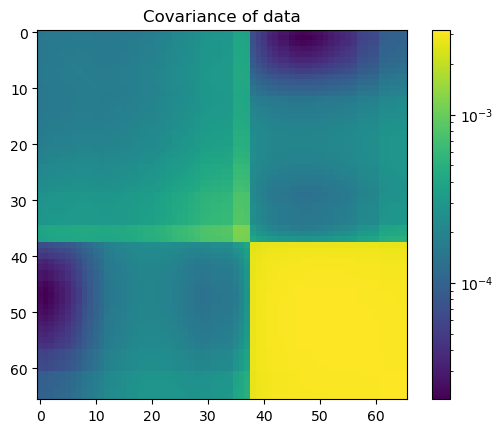

In [10]:
subsample = np.arange(0,Xm.shape[0],100)
# Xsub = X[subsample,:]
Xsub = Xm[subsample,:]

mean = Xsub.mean(axis=0)
Cov  = ma.cov(Xsub, rowvar=False)

plt.imshow(Cov, norm=LogNorm())
plt.colorbar()
plt.title('Covariance of data')

### 5.2 Principal Components

For techniques like Principal Component Analysis (PCA), the covariance matrix is key to determining the principal components, which are the directions of maximum variance (and hence information) in the data. PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. 

PCA starts by computing the covariance matrix of the data, which measures how changes in one variable are associated with changes in another.

The covariance matrix is then decomposed into its eigenvectors and eigenvalues. This is a key step in PCA, as the eigenvectors determine the directions of the new feature space, and the eigenvalues determine their magnitude. In the context of PCA, the eigenvectors are called principal axes or principal directions of the data.

The eigenvectors are sorted by the corresponding eigenvalues in descending order. This order determines the importance of each principal component, with the principal component corresponding to the highest eigenvalue being the most significant.

The eigenvalues give the variance explained by each principal component. The sum of the eigenvalues gives the total variance in the data. By dividing each eigenvalue by the sum of all eigenvalues, we get the proportion of variance explained by each principal component.

The resulting principal components are orthogonal to each other, which means that they are uncorrelated (the correlation is zero).

PCA is particularly usefule in hyperspectral image analysis for several reasons: Dimensionality reduction, noise reduction, feature extraction, change detection, correlation structure, spectral unmixing

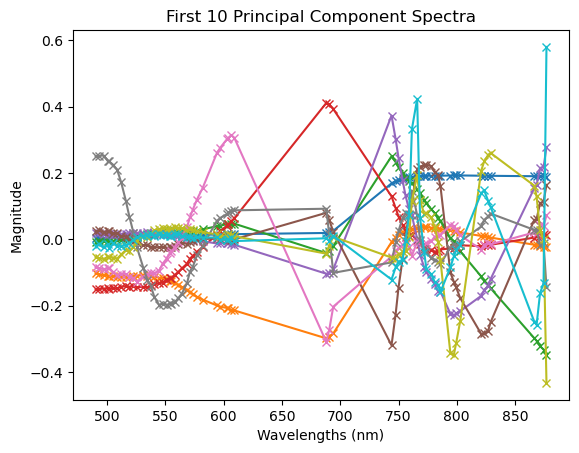

In [11]:
ev, evec = eig(Cov.data)

for i in range(10):
    # plt.cla()
    plt.plot(wavelengths,evec[:,i], marker='x')
    plt.xlabel('Wavelengths (nm)')
    plt.ylabel('Magnitude')
    plt.title('First 10 Principal Component Spectra')

#### Intrinsic Dimensionality

The intrinsic dimensionality of a dataset refers to the number of variables needed to represent the underlying structure of the data. In other words, it's the minimum number of dimensions that captures the essential variability of the data without significant loss of information. PCA can be used to estimate intrinsic dimensionality by looking at the eigenvalues of the covariance matrix. The intrinsic dimensionality can be estimated as the number of principal components that account for a significant portion of the variance in the data. The concept of intrinsic dimensionality is tied to the idea of information preservation where goal is to find the lowest dimensionality that preserves the "information" defined as the structure and variability in the data.

Text(0, 0.5, 'Log eigenvalue')

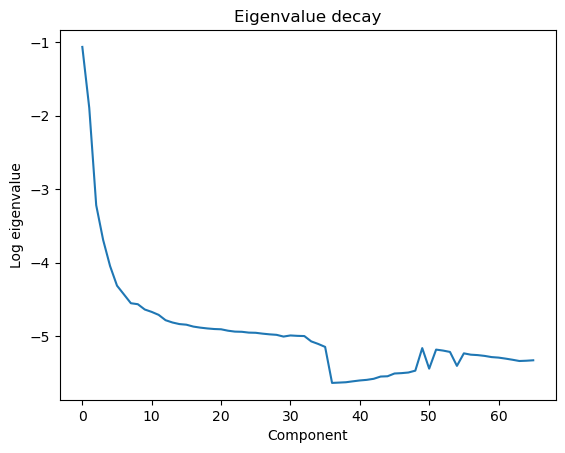

In [12]:
# Calculate mean, covariance, and the covariance eigenvectors
mu = Xsub.mean(axis=0)
Cov = ma.cov(Xsub, rowvar=False)
ev, evec = eig(Cov.data)

# intrinsic dimensionality
plt.plot(np.arange(len(wavelengths)), np.log10(ev))
plt.title('Eigenvalue decay')
plt.xlabel('Component')
plt.ylabel('Log eigenvalue')

Create xarray dataset of the PCA eigenvalues, with each component representing a different, uncorrelated band, and visualize the new PC dataset. 

In [13]:
rows = imgMat0.shape[1]
cols = imgMat0.shape[2]
bands = imgMat0.shape[0]

numPC = 10
X_zeromean = Xm - mu
X_proj = np.zeros((numPC, rows, cols))
for i in range(0,numPC,1):
    print('eigenvalue %i'%i)
    X_fixed = np.matmul(X_zeromean, evec[:,i])
    X_proj[i,:,:] = X_fixed.data.reshape((rows,cols))
X_proj.shape 

# Create the DataArray
PCs_ds = xr.DataArray(X_proj, coords=[np.arange(numPC), data.y, data.x], dims=["PC", "x", "y"])

# interactive band visualizer
plot = PCs_ds.hvplot(x='y', y='x', 
                   groupby='PC',  # Group by band
                   cmap='viridis', 
                   aspect='equal', rasterize=True,
                   # crs=ccrs.PlateCarree(),
                   # tiles='EsriImagery',
                   width=700,
                   height=700,
                   widget_location='top')

pn.serve(plot) 

eigenvalue 0
eigenvalue 1
eigenvalue 2
eigenvalue 3
eigenvalue 4
eigenvalue 5
eigenvalue 6
eigenvalue 7
eigenvalue 8
eigenvalue 9
Launching server at http://localhost:51718


## 6. Case Study: Assessing vegetation health using hyperspectal imagery

### 6.1 Spectral Indices

One of the most powerful tools in this domain is the use of vegetation indices – numerical indicators derived from satellite and aerial imagery that quantify various aspects of plant health and vigor. This tutorial aims to introduce you to the fundamental concepts and applications of these indices in monitoring vegetation health and stress.


Vegetation indices are based on the principle that different surfaces reflect solar radiation in unique ways. Healthy vegetation, for instance, absorbs most of the visible light (particularly the red wavelength) for photosynthesis and reflects a larger portion of the near-infrared light. By contrasting these spectral bands, we can deduce critical information about plant health, growth stages, and stress levels. Broadly speaking, healthy plants (those rich in chlorophyll) reflect more near-infrared (NIR) and green light than those with stressed or dead leaves.

![Leaf Health](/Users/jeremy/git/piView/setup/leaf_health.png "Leaf Health")

Specifically, Normalized Difference Vegetation Index (NDVI) works by comparing red and NIR light to identify the amount of chlorophyll in leaves. Initially it was used simply to detect the presence of vegetation, but adopted to quantify photosynthetic capacity, a key indicator of plant health. NDVI can make a good indicator of plant health, but lacks subtlety and can reach saturation easily. Thus a range of vegetation indices (VIs) have been developed to complement NDVI. Some of the more popular ones:

### 6.2 Broadband versus Narrowband Indices 

Broadband vegetation indices, such as the widely used Normalized Difference Vegetation Index (NDVI), are calculated using broad spectral bands, typically the red and near-infrared regions of the electromagnetic spectrum. While these indices have been valuable for general vegetation monitoring, they have several limitations, which have been described above (saturation, lack of sensitivity, atmosphere and soil effects,…)

Narrowband indices offer several advantages:

1.	Increased Sensitivity to Vegetation Properties: Hyperspectral sensors measure the reflected or emitted electromagnetic radiation in hundreds of narrow, contiguous spectral bands, allowing for the calculation of indices that are sensitive to specific vegetation properties. For example, narrowband indices can track changes in chlorophyll content, carotenoid levels, plant water content, and other biochemical or biophysical parameters.
2.	Improved Accuracy at High Biomass Levels: Narrowband indices, particularly those utilizing the "red edge" region of the spectrum (around 700-750 nm), are less prone to saturation at high biomass levels, enabling more accurate monitoring of dense vegetation canopies.
3.	Improved Discrimination of Vegetation Types and Conditions: The high spectral resolution of hyperspectral data allows for the development of specialized indices that can better differentiate between different vegetation types, growth stages, and stress conditions.
4.	Reduced Atmospheric and Background Influence: Certain narrowband indices can be designed to minimize the influence of atmospheric effects and soil background variations, resulting in more reliable and accurate vegetation measurements.
5.	Early Detection of Stress and Nutrient Deficiencies: The ability to track specific biochemical and biophysical properties using narrowband indices can enable early detection of plant stress, nutrient deficiencies, or disease before they become visually apparent, allowing for timely interventions and management practices.


In [14]:
# define bands
band_centers = pd.DataFrame(wavelengths,columns=['center'])
get_band_number = lambda w: (band_centers.center-w).abs().argmin()

redB = imgMat0[get_band_number(670),:,:]
nirB = imgMat0[get_band_number(800),:,:]
blueB = imgMat0[get_band_number(470),:,:]
grnB = imgMat0[get_band_number(560),:,:]
redgB = imgMat0[get_band_number(730),:,:]
swirB = imgMat0[get_band_number(900),:,:]
b550 = imgMat0[get_band_number(550),:,:]
b670 = imgMat0[get_band_number(670),:,:]
b530 = imgMat0[get_band_number(530),:,:]
b850 = imgMat0[get_band_number(850),:,:]
b710 = imgMat0[get_band_number(710),:,:]
b680 = imgMat0[get_band_number(680),:,:]
b531 = imgMat0[get_band_number(531),:,:]
b570 = imgMat0[get_band_number(570),:,:]
b500 = imgMat0[get_band_number(500),:,:]
b750 = imgMat0[get_band_number(750),:,:]
b510 = imgMat0[get_band_number(510),:,:]
b700 = imgMat0[get_band_number(700),:,:]
b800 = imgMat0[get_band_number(800),:,:]

# BROADBAND INDICES

# normalized difference vegetation index
ndvi = (nirB - redB) / (nirB + redB)
# enhanced vegetation index 2
evi2 = 2.5 * (nirB - redB) / (nirB + 2.4 * redB + 1)
# visible atmospherically resistant index
vari = (grnB - redB) / (grnB + redB - blueB)
# soil adjusted vegetation index
savi = (nirB - redB) / (nirB + redB + .5) * (1 + .5) 
# normalized difference water index
ndwi = (grnB - nirB) / (grnB + nirB)

# NARROWBAND INDICES

# modified triangular vegetation index 2
mtvi2 = 1.5 * (1.2 * (nirB - b550) - 2.5 * (b670 - b550)) / np.sqrt((2 * nirB + 1) ** 2 - (6 * nirB - 5 * np.sqrt(b670)) - .5) 
# normalized difference red edge 
ndre = (nirB - redgB) / (nirB + redgB)
# green chlorophyll index
gci = redgB / b530 - 1
# modified chlorophyll absorption reflectance index
mcari = ((b850 - b710) - 0.2 * (b850 - b530)) / b710
# structure insensitive pigment index
sipi = (nirB - blueB) / (nirB - b680)
# photochemical reflectance index
pri = (b531 - b570) / (b531 + b570)
# plant senescence reflectance index
psri = (b680 - b500) / b750
# carotenoid reflectance index
cri2 = ((1/b510) - (1/b700))
# anthocyanin reflectance index
ari2 = b800 * ((1/grnB) - (1/b700))


### 6.3 Plot Vegetation Indices

Similar to previous interactive plots, we will put all the index products into a xarray datarray to create an interactive environment to visualize various vegetation health indices. 

In [ ]:
import numpy as np
import xarray as xr
import hvplot.xarray
import panel as pn

# Define the clipping ranges for each index
clipping_ranges = {
    'NDVI': (-1, 1),
    'EVI2': (-1, 2),
    'VARI': (-1, 2),
    'SAVI': (0, 1),
    'NDWI': (-1, 1),
    'MTVI2': (-1, 10),
    'NDRE': (-1, 10),
    'GCI': (0, 50),
    'MCARI': (-.5, 10),
    'SIPI': (0, 10),
    'PRI': (-.2, 1),
    'PSRI': (-1, 5),
    'CRI2': (0, 50),
    'ARI2': (0, 50),
}

VInames = list(clipping_ranges.keys())
VIs = [ndvi, evi2, vari, savi, ndwi, mtvi2, ndre, gci, mcari, sipi, pri, psri, cri2, ari2]

# Clip and remove outliers for each VI
clipped_VIs = []
for name, vi in zip(VInames, VIs):
    clip_min, clip_max = clipping_ranges[name]
    clipped_vi = preprocess_vi(vi, clip_min, clip_max)
    clipped_VIs.append(clipped_vi)

# Create empty dataset
rows, cols = VIs[0].shape  # Assuming all VIs have the same shape
Vproj = np.zeros((len(VInames), rows, cols))

for i in range(len(VInames)):
    Vproj[i, :, :] = clipped_VIs[i]

y = Vproj[0, 0, :]   # X coordinates
x = Vproj[0, :, 0]   # Y coordinates

# Create the DataArray
VI_ds = xr.DataArray(Vproj, coords=[VInames, data.y, data.x], dims=["idx", "x", "y"])

# Interactive band visualizer
plot = VI_ds.hvplot(x='y', y='x', 
                   groupby='idx', 
                   cmap='turbo', 
                   aspect='equal', rasterize=True,
                   width=700,
                   height=700,
                   widget_location='top')

pn.serve(plot)


Launching server at http://localhost:51726


### 6.4 Cluster Image

Lets delete a bunch of unnecessary variables to free up some space and remove all of the NaN padding around the image so that we have a 2-D array of just spectra before we cluster. We will also mask out pixels below an NDVI of 0.4 so that we are confident we are only clustering vegetation pixels.

In [ ]:
# delete unnecessary variables to save memory
del unc, X0, Xsub, mu, Cov, ev, evec, X_zeromean, X_proj, redB, nirB, blueB, grnB, redgB, swirB, b550, b670, b530, b850, b710, b680, b531, b570, b500, b750, b510, b700, b800, evi2, vari, savi, ndwi, mtvi2, ndre, gci, mcari, sipi, pri, psri, cri2, ari2, VIs, clipped_VIs, y, x, VI_ds,

# mask for vegetation pixels only
ndvi_mask = ndvi >= .3
masked_data = data.where(ndvi_mask)
imgMat1 = masked_data.values
# Reshape the 3D array to 2D
X1 = imgMat1.reshape(n_features, n_samples).T
# mask nans
Xm1 = ma.masked_invalid(X1)

# Prep image for clustering
imgFlatSpecDf = pd.DataFrame(Xm1, columns=wavelengths)
nans_removed_spec = imgFlatSpecDf.dropna()
print (nans_removed_spec.shape)

nans_removed_spec_norm = normalize(nans_removed_spec)
# nans_removed_spec_norm = pd.DataFrame(nans_removed_spec_norm, index=nans_removed_spec.index.values, columns=cols)
nans_removed_spec_norm = pd.DataFrame(nans_removed_spec_norm, index=nans_removed_spec.index.values, columns=wavelengths)

# this can take 10+ minutes...
# elbow(nans_removed_spec_norm)

(2702997, 66)


K-means clustering is an unsupervised machine learning algorithm used to group data into clusters based on similarity. In hyperspectral image (HSI) analysis, it is particularly useful for segmenting the data into regions with similar spectral characteristics, enabling identification of materials or land cover types without prior knowledge. By treating each pixel's spectral signature as a data point, K-means assigns pixels to clusters, revealing patterns and relationships in the data. This method is widely applied in tasks like feature extraction, target detection, and environmental monitoring, helping to simplify complex hyperspectral datasets for further analysis.

In [26]:
# Run clustering for normalized feature dataset

# Number of clusters
nclust = 5

# run Kmeans
labels = kmeans_clust(nans_removed_spec_norm, nclust)

# Save the original indices of non_nan_rows
original_indices = nans_removed_spec_norm.index

# Create a new DataFrame with the same number of rows as original img filled with nans
new_imgFlat = pd.DataFrame(index=imgFlatSpecDf.iloc[:,0].index, columns=['cluster'])
new_imgFlat[:] = np.nan

# Insert the processed rows back into the new DataFrame at their original indices
new_imgFlat.loc[original_indices] = labels.reshape(-1,1)

# create cluster image
clusterImgSpec = new_imgFlat.values.reshape(imgMat0.shape[1], imgMat0.shape[2])

/Users/jeremy/miniforge3/envs/pixxel_viewer/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 6.5 Visualize clusters

An overlay viewer with a sliding feature between a clustered image and an RGB image is a powerful tool for hyperspectral data analysis. It allows users to visually compare the results of clustering with the original spatial and spectral context provided by the RGB image. This interactive functionality enhances understanding of how clusters align with real-world features, aids in validating segmentation results, and supports more intuitive interpretation of the data. By seamlessly switching between views, it becomes easier to identify patterns, verify targets, and refine analysis outcomes.

In [27]:

# function for overlay viewer
def interactive_overlay(rgb_image, classification_map):
    def update_plot(alpha=1.0):
        # Create a figure
        plt.figure(figsize=(12, 12))

        # Plot the RGB image
        plt.imshow(rgb_image)
        plt.title('RGB Image')

        # Plot the classification map with adjustable transparency
        overlay = classification_map.copy()
        overlay[overlay < 0] = 0  # Ensure values are non-negative
        plt.imshow(overlay, cmap='jet', alpha=alpha, )
        plt.title(f'Classification Map (Alpha={alpha:.2f})')

        plt.axis('off')
        plt.show()

    # Create an interactive slider for transparency (alpha)
    alpha_slider = widgets.FloatSlider(
        value=1.0,
        min=0.0,
        max=1.0,
        step=0.02,
        description='Alpha:'
    )

    # Create the interactive widget
    widget = widgets.interactive(update_plot, alpha=alpha_slider)
    display(widget)

# Example data: Replace these with your own RGB image and classification map
# Make sure your classification_map has the same dimensions as the RGB image.

interactive_overlay(np.dstack((rgb_norm.data)), clusterImgSpec.astype(float))


interactive(children=(FloatSlider(value=1.0, description='Alpha:', max=1.0, step=0.02), Output()), _dom_classe…

## 6. Case Study: Targeted Mineral Mapping

### 6.1 Spectral similarity and spectral angle mapper (SAM)

Spectral similarity techniques are fundamental in hyperspectral imaging (HSI) analysis, enabling the identification and classification of materials based on their unique spectral signatures. One of the most widely used methods is the Spectral Angle Mapper (SAM). SAM is a powerful, geometry-based algorithm that measures the spectral similarity between two spectral vectors—typically the reference spectrum and the spectrum of a pixel in the HSI data.

SAM works by calculating the angle between these vectors in a multidimensional spectral space, treating them as direction vectors rather than magnitude-dependent values. This angle is invariant to the magnitude of the spectra, making SAM robust to variations in illumination and albedo. The smaller the spectral angle, the higher the similarity, allowing for precise material classification or matching. SAM is particularly advantageous due to its computational simplicity and effectiveness in distinguishing between spectrally distinct materials.  However, SAM assumes a linear relationship in the spectral space, which may limit its efficacy in cases of non-linear spectral mixing. Despite this, SAM remains a cornerstone technique in hyperspectral data interpretation.

This example uses the SAM method to identify muscovite in Cuprite, Nevada. This region has been down for diverse mineral assemblages and a hotspot for mineral identification experiments. We use a groundtruth spectrum of a muscovite spectrum from the USGS spectral library and run SAM over the entire image to find closest matches. For SAM, the lower the value, the closer the match.

In [ ]:
# path to image and uncertianty cubes
fpath = '/Users/jeremy/images/TD1_7400_L0_V1/isofit/output/7400_rfl_rfl'
fpath_unc = '/Users/jeremy/images/TD1_7400_L0_V1/isofit/output/7400_uncert_uncert'
# path to metadata file
hdrpath = '/Users/jeremy/images/TD1_7400_L0_V1/isofit/output/7400_rfl_rfl.hdr'

# parse center wavelengths and FWHM from header file
wavelengths, fwhms = parse_hdr_file(hdrpath)

# Display the results
print("Wavelengths:", wavelengths)
print("FWHM:", fwhms)

# open dataset as xarray dataset
data = rioxarray.open_rasterio(fpath, driver='ENVI')
unc = rioxarray.open_rasterio(fpath_unc, driver='ENVI')
data = data.where(data != -9999, np.nan)
unc = unc.where(data != -9999, np.nan)

# replace band numbers with wavelengths
# Check if the number of wavelengths matches the number of bands
if len(wavelengths) == data.band.size:
    # Replace the band numbers with wavelength values
    data = data.swap_dims({'band':'wavelength'})
    # data = xr.open_dataarray(path)
    data.name = 'reflectance'
else:
    print("The number of wavelengths does not match the number of bands in the image dataset.")

if len(wavelengths) == unc.band.size:
    # Replace the band numbers with wavelength values
    unc = unc.swap_dims({'band':'wavelength'})
    # data = xr.open_dataarray(path)
    unc.name = 'uncertainty'
else:
    print("The number of wavelengths does not match the number of bands in the uncertainty dataset.")


# Assuming 'data' and 'unc' are your xarray DataArrays
# transform linear_stretch or brighten
rgb_norm = spec_viz(data, unc, transform='linear_stretch')

Wavelengths: [490.0, 493.0, 497.0, 500.5, 501.5, 505.0, 508.5, 512.0, 516.0, 519.0, 522.5, 525.5, 531.0, 534.5, 537.5, 540.5, 544.5, 547.5, 551.0, 554.0, 555.0, 558.0, 561.0, 564.0, 568.5, 571.0, 573.5, 577.0, 582.0, 594.0, 597.0, 600.0, 603.0, 604.0, 606.5, 609.0, 690.5, 694.0, 744.0, 747.5, 750.0, 753.5, 756.0, 759.0, 761.5, 766.0, 768.5, 772.0, 774.0, 778.0, 781.0, 784.0, 786.0, 794.5, 797.5, 799.5, 803.0, 821.0, 823.5, 827.0, 829.0, 866.5, 868.5, 871.5, 874.5, 877.0]
FWHM: [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
Launching server at http://localhost:52948


Text(0.5, 1.0, 'Muscovite')

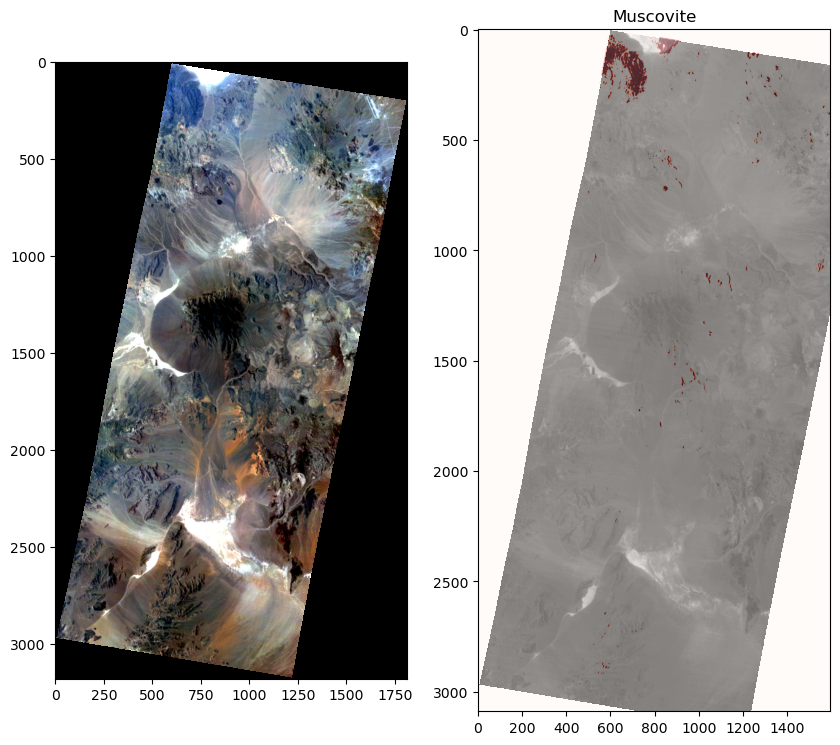

In [ ]:
# Run spectral angle mapper

# prepare the target mineral spectra
min_spectra = pd.read_csv('test_mineral_spectra.csv')
min_wl = min_spectra.wl
muscovite = min_spectra.Muscovite.values

# to TD wavelengths
muscovite_TD = np.interp(wavelengths, min_wl, muscovite)

# image info
imgMat1 = data.values
X = imgMat1.copy()
rows = imgMat0.shape[1]
cols = imgMat0.shape[2]


# calculate spectral angle for all spectra for each mineral
musc = np.zeros((rows,cols))

for r in range(rows):
    for c in range(cols):
        rfl = np.squeeze(X[:,r,c])
        if np.isnan(rfl).any():
            continue

        angle = np.arccos(muscovite_TD.dot(rfl)/(norm(muscovite_TD)*norm(rfl)))
        musc[r,c] = angle

musc = np.where(musc == 0, np.nan, musc)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(np.transpose(rgb_norm.data, (1, 2, 0)))
ax[1].imshow(X[5,:,:], cmap='gray')
ax[1].imshow(musc < .1, cmap='Reds', alpha=.4)
ax[1].set_title('Muscovite')



